In [23]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

In [24]:
embedding_dim = 100
max_length = 16
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_size = 16000
test_portion = .1

corpus = []

In [25]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv

--2019-09-06 06:15:08--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.15.112, 2607:f8b0:4004:811::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.15.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M   160MB/s    in 1.4s    

2019-09-06 06:15:09 (160 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



In [26]:
num_sentences = 0

with open("/tmp/training_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        list_item = []
        list_item.append(row[5])
        this_label = row[0]
        if this_label == '0':
            list_item.append(0)
        else:
            list_item.append(1)
        num_sentences = num_sentences + 1
        corpus.append(list_item)

In [27]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [28]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])

In [29]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size = len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen = max_length, padding=padding_type, truncating=trunc_type)

split = int(test_portion*training_size)
test_sequences = padded[0: split]
training_sequences = padded[split: training_size]
test_labels = labels[0: split]
training_labels = labels[split: training_size]

In [37]:
print(vocab_size)
print(word_index['i'])

26457
1


In [39]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;
        
embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2019-09-06 06:29:04--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.15.112, 2607:f8b0:4004:811::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.15.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M  99.2MB/s    in 3.3s    

2019-09-06 06:29:08 (99.2 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [41]:
print(len(embeddings_matrix))

26458


In [43]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

num_epochs = 50
test_labels = np.array(test_labels)
training_labels = np.array(training_labels)
history = model.fit(training_sequences, training_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels), verbose=2)
print('Training complete')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 16, 100)           2645800   
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 100)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 64)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 2,710,953
Trainable params: 65,153
Non-trainable params: 2,645,800
_______________________________________

W0906 06:42:01.410952 140435106109248 deprecation.py:323] From /opt/tljh/user/lib/python3.6/site-packages/tensorflow_core/python/ops/nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


14400/14400 - 5s - loss: 0.6268 - accuracy: 0.6440 - val_loss: 0.5853 - val_accuracy: 0.6894
Epoch 2/50
14400/14400 - 3s - loss: 0.5745 - accuracy: 0.6948 - val_loss: 0.5772 - val_accuracy: 0.7013
Epoch 3/50
14400/14400 - 3s - loss: 0.5399 - accuracy: 0.7234 - val_loss: 0.5966 - val_accuracy: 0.6694
Epoch 4/50
14400/14400 - 3s - loss: 0.5133 - accuracy: 0.7444 - val_loss: 0.5664 - val_accuracy: 0.7131
Epoch 5/50
14400/14400 - 3s - loss: 0.4892 - accuracy: 0.7625 - val_loss: 0.6145 - val_accuracy: 0.6913
Epoch 6/50
14400/14400 - 3s - loss: 0.4597 - accuracy: 0.7790 - val_loss: 0.5892 - val_accuracy: 0.6981
Epoch 7/50
14400/14400 - 3s - loss: 0.4319 - accuracy: 0.7949 - val_loss: 0.6069 - val_accuracy: 0.6981
Epoch 8/50
14400/14400 - 3s - loss: 0.4086 - accuracy: 0.8072 - val_loss: 0.6341 - val_accuracy: 0.6794
Epoch 9/50
14400/14400 - 3s - loss: 0.3833 - accuracy: 0.8240 - val_loss: 0.6350 - val_accuracy: 0.6975
Epoch 10/50
14400/14400 - 3s - loss: 0.3656 - accuracy: 0.8330 - val_loss: 

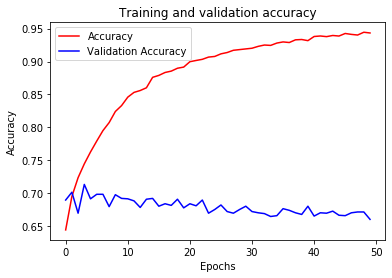

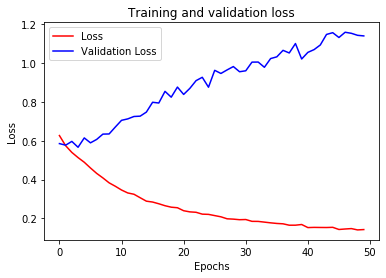

<Figure size 432x288 with 0 Axes>

In [49]:
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure();

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure();